In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
#DecisionTreeClassifier 생성
dt_clf = DecisionTreeClassifier(random_state = 156)

In [3]:
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = 0.2, random_state = 11)

# DecisionTreeClassifier로 학습
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [4]:
from sklearn.tree import export_graphviz

In [5]:
# export_graphviz 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함.
export_graphviz(dt_clf, out_file = "tree.dot", class_names = iris_data.target_names, \
               feature_names = iris_data.feature_names, impurity=True, filled = True)

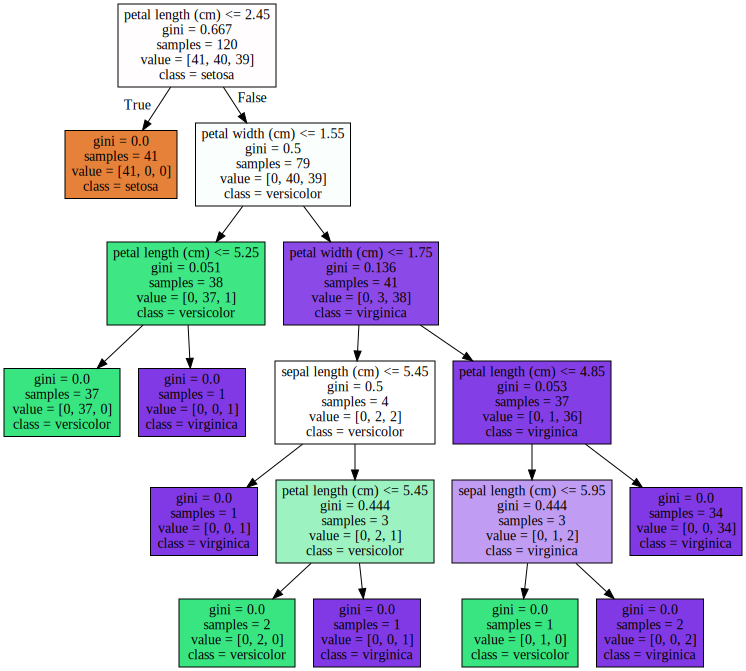

In [6]:
import graphviz
#위에서 생성된 tree.dot 파일을 Graphviz가 읽어서 주피터 노트북상에서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

- 1번 노드:
samples는 120개, value는 차례로 Setosa, Versicolor, Virginia 데이터 갯수
분포도에 따라 지니계수 계산

- 규칙에 따라 2,3번 노드 생성:
2번 노드는 리프 노드이고 지니계수는 0 (완전 평등)
3번은 여전히 지니계수 0.5보다 높음

- 이후 노드들 지니계수 점점 낮아진다

- 노드의 색깔은 붓꽃 데이터의 레이블 값 의미
- 주황, 초록, 보라 => Setosa, Versicolor, Virginia
- 색깔 짙을수록 지니계수가 낮고 해당 레이블에 속하는 샘플 데이터가 많다는 뜻

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


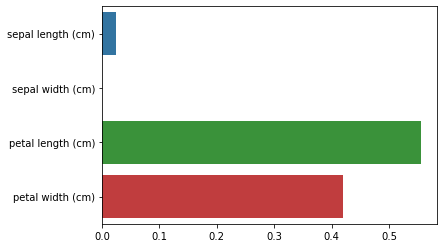

In [7]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_,3)))

# feature별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
    
# feature importance를 column 별로 시각화하기
sns.barplot(x= dt_clf.feature_importances_, y = iris_data.feature_names)

## 결정트리 과적합

In [8]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

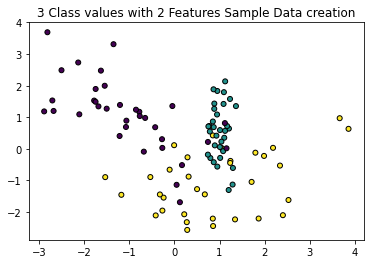

In [9]:
plt.title("3 Class values with 2 Features Sample Data creation")

#2차원 시각화를 위해 피처는 2개, 클래스는 3가지 유형의 분류 샘플 데이터 생성
X_features, y_labels = make_classification(n_features = 2, n_redundant = 0, n_informative = 2, n_classes = 3, n_clusters_per_class = 1, random_state = 0)

#그래프 형태로 2개의 피처로 2차원 좌표 시각화, 각 클래스 값은 다른 색깔로 표시됨
plt.scatter(X_features[:,0], X_features[:,1], marker = 'o', c = y_labels, s=25, edgecolor = 'k')

In [10]:
# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

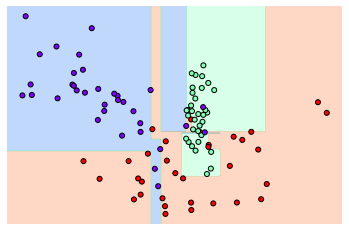

In [11]:
# 특정한 트리 생성 제약 없는 결정 트리의 학습가 결정 경계 시각화.
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

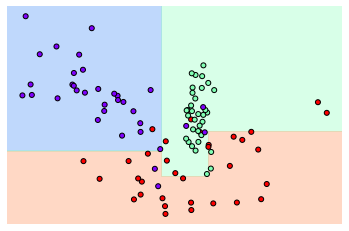

In [12]:
# min_samples_leaf = 6으로 트리 생성 조건을 제약한 결정 경계 시각화
dt_clf = DecisionTreeClassifier(min_samples_leaf = 6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

## GBM (Gradient Boosting Machine)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv("./human_activity/features.txt",sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

from sklearn.metrics import accuracy_score

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time()-start_time))